In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

import shap

d:\anaconda3\envs\cbm_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import the dataset
df = pd.read_csv('../data/ai4i2020.csv')

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
# show duplicated rows
df['Product ID'].duplicated().sum()

0

# Exploratory Data Analysis
## Class Imbalance

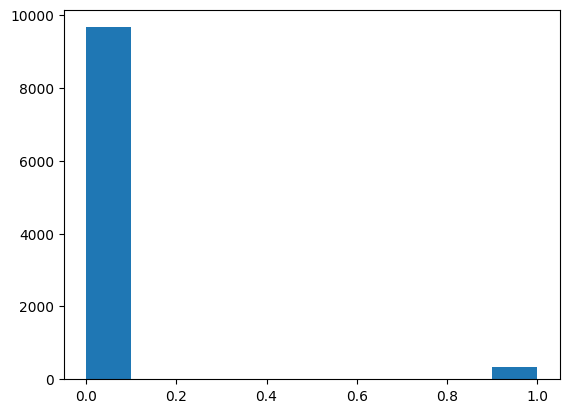

In [5]:
# show the overall machine failure distributions
plt.hist(df['Machine failure'])
plt.show()

## Product Quality

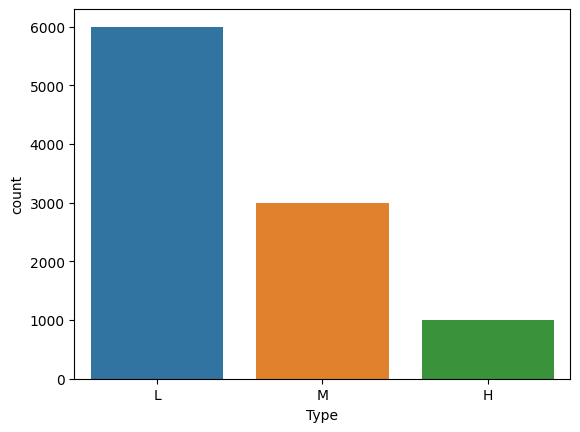

In [6]:
# show the distribution of product types L, M, H
sns.countplot(data=df, x='Type', order=df['Type'].value_counts().index)
plt.show()

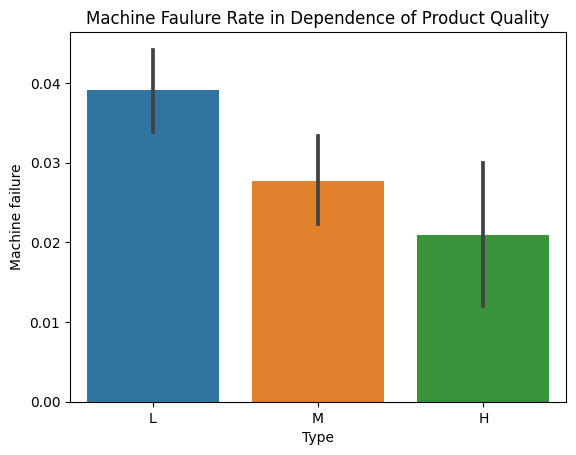

In [7]:
# show the machine failure distributions for the three different product quality categories L, M, H
plt.title('Machine Faulure Rate in Dependence of Product Quality')
sns.barplot(data=df, x='Type', y='Machine failure', order=df['Type'].value_counts().index)
plt.show()

# Feature Engineering
## Add Outlier Feature using Isolation Forest Algorithm

In [8]:
# define features i.e. physical parameters potentially leading to machine failure
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
df[features]

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.1,308.5,1498,49.4,5
3,298.2,308.6,1433,39.5,7
4,298.2,308.7,1408,40.0,9
...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14
9996,298.9,308.4,1632,31.8,17
9997,299.0,308.6,1645,33.4,22
9998,299.0,308.7,1408,48.5,25


In [9]:
from pyod.models.iforest import IForest

In [10]:
iforest = IForest(contamination=0.05, n_jobs=-1)
outier_labels = iforest.fit_predict(df[features])

Function fit_predict is deprecated


In [11]:
outier_labels.sum()

500

In [12]:
df['outlier'] = outier_labels

In [13]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,outlier
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0


In [14]:
features.append('outlier')

In [15]:
features

['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'outlier']

In [16]:
df[features].head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],outlier
0,298.1,308.6,1551,42.8,0,0
1,298.2,308.7,1408,46.3,3,0
2,298.1,308.5,1498,49.4,5,0
3,298.2,308.6,1433,39.5,7,0
4,298.2,308.7,1408,40.0,9,0


## Boxplots

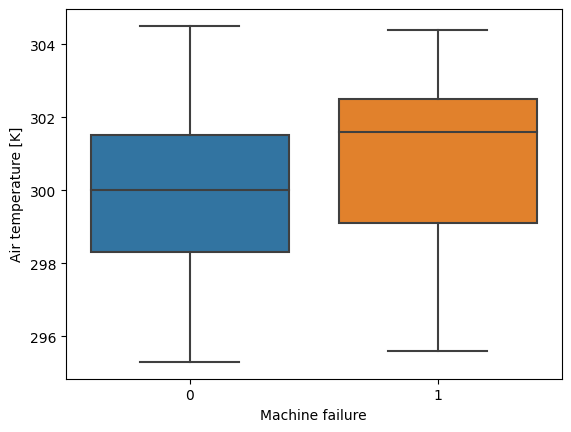

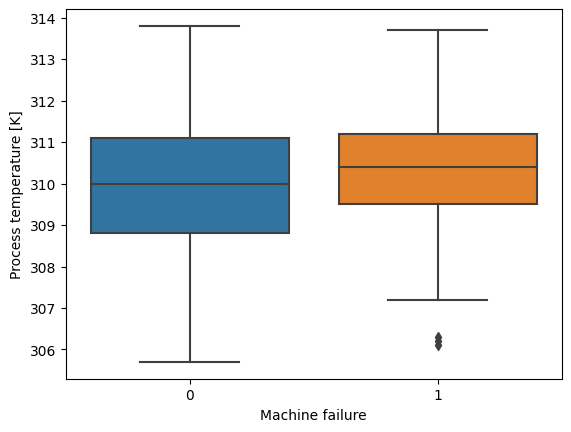

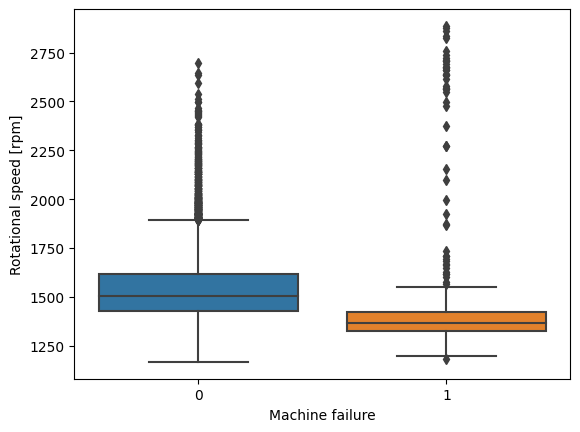

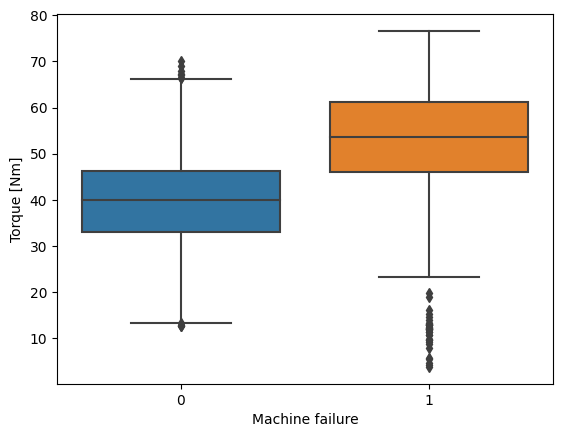

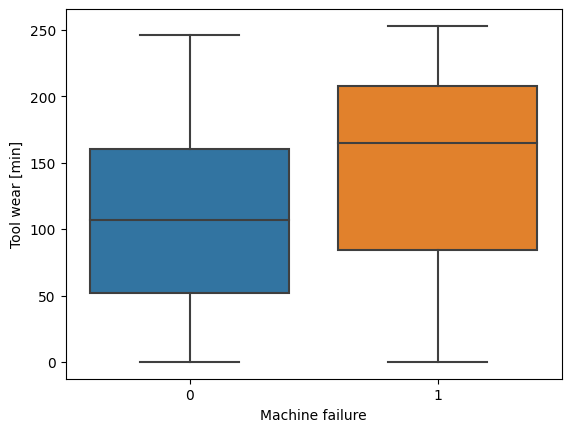

In [17]:
for f in features[:-1]:
    sns.boxplot(df, y=f, x='Machine failure')
    plt.show()

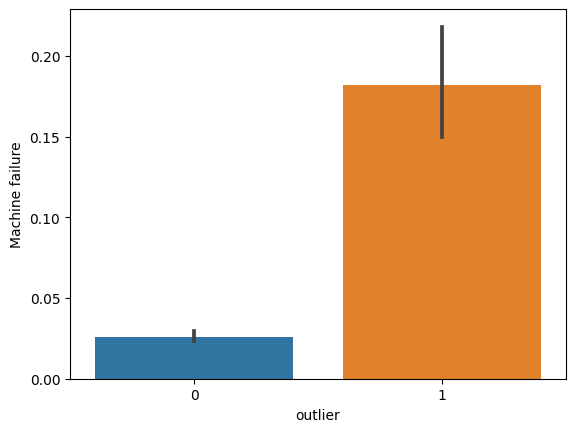

In [18]:
sns.barplot(df, x='outlier', y='Machine failure')
plt.show()

In [19]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
       'outlier'],
      dtype='object')

Air temperature [K] Process temperature [K]
Air temperature [K] Rotational speed [rpm]
Air temperature [K] Torque [Nm]
Air temperature [K] Tool wear [min]
Process temperature [K] Rotational speed [rpm]
Process temperature [K] Torque [Nm]
Process temperature [K] Tool wear [min]
Rotational speed [rpm] Torque [Nm]
Rotational speed [rpm] Tool wear [min]
Torque [Nm] Tool wear [min]


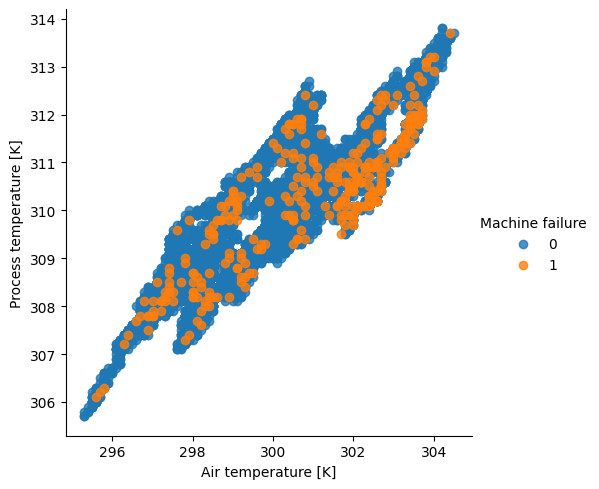

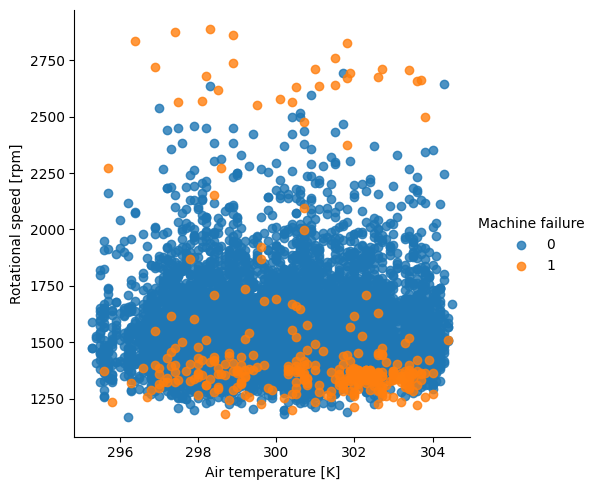

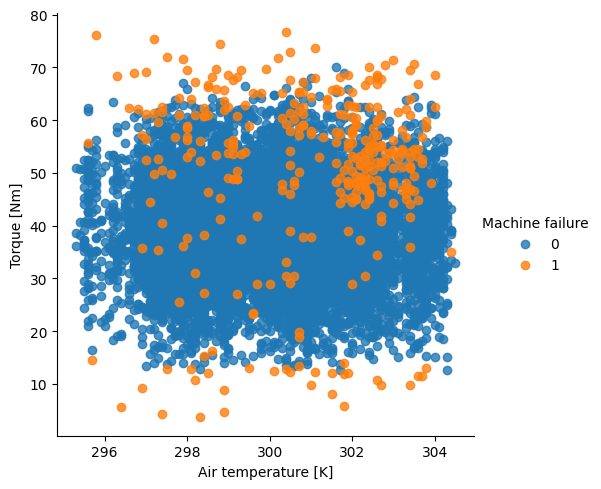

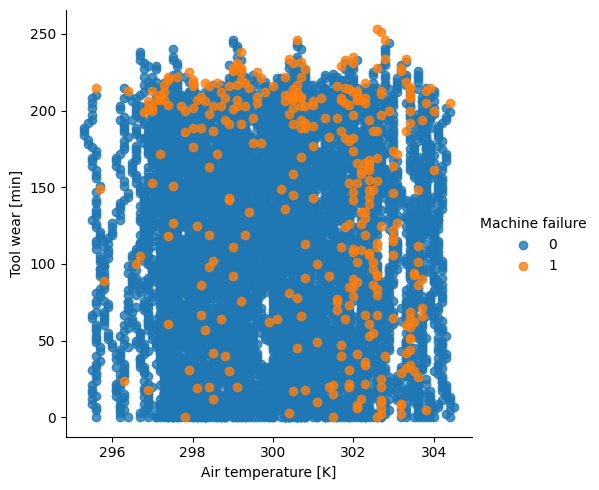

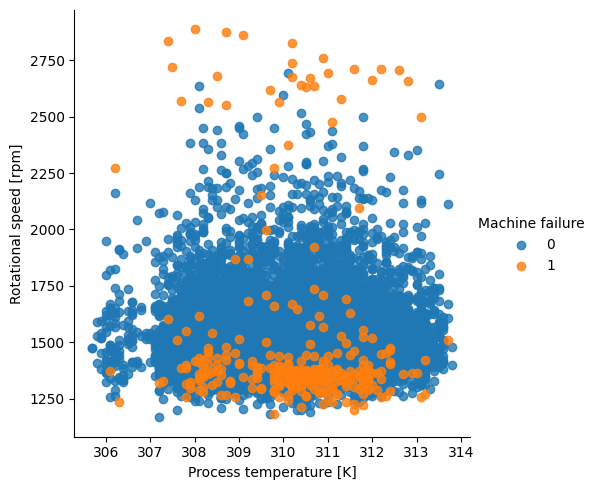

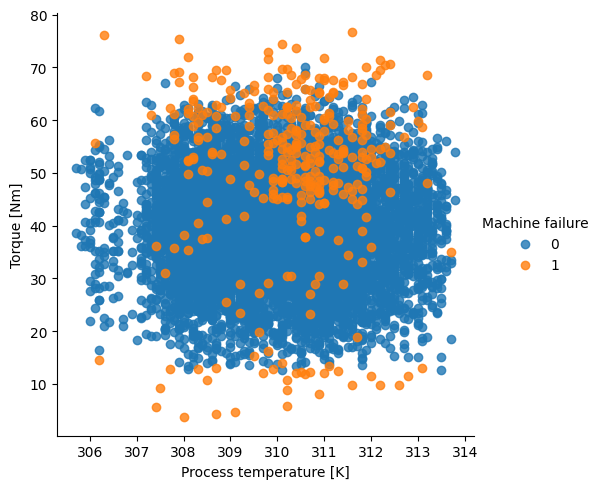

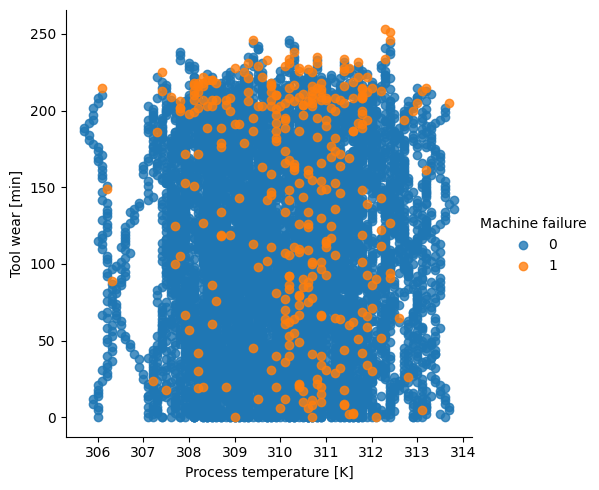

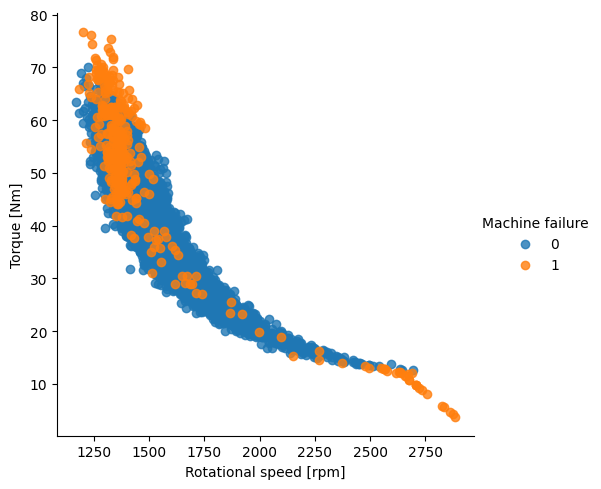

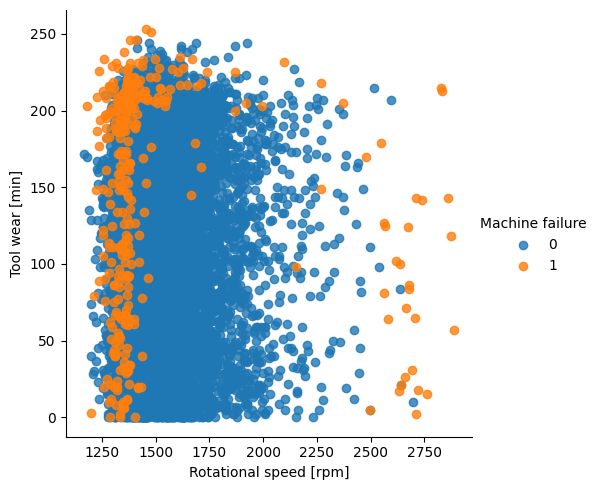

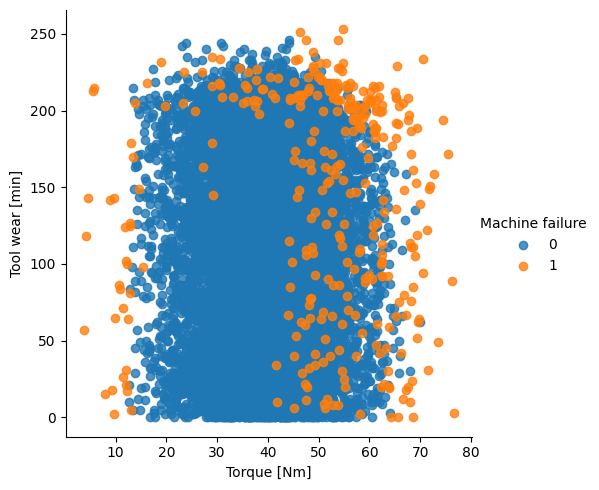

In [36]:
# Generate all combinations of features
combinations = list(itertools.combinations(features[:-1], 2))
for c in combinations:
    print(c[0], c[1])
    sns.lmplot(x=c[0], y=c[1], hue='Machine failure', data=df, fit_reg=False)

# Machine Learning Modeling

In [37]:
# separate features and target
X = df[features]
y = df['Machine failure']

In [38]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

## Fit Linear Classification Model

In [39]:
clf = LogisticRegression(class_weight='balanced', random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

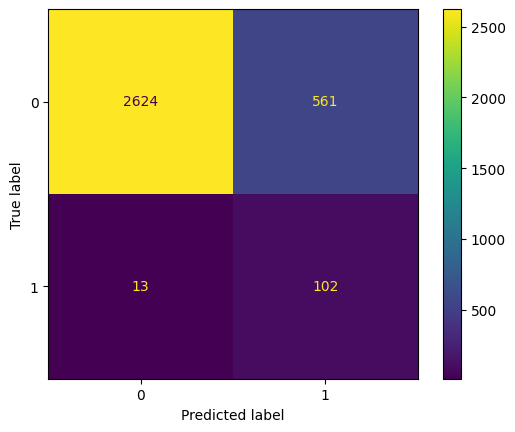

In [40]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

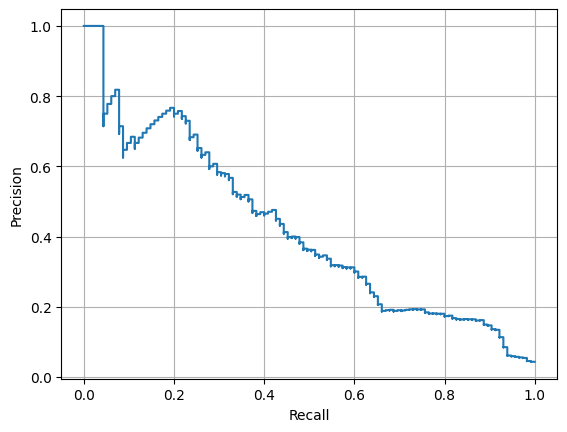

In [41]:
# precision recall curve
y_score = clf.decision_function(X_test)
prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.grid()

## Fit Gradient Boosting Classifier

In [42]:
clf = GradientBoostingClassifier(random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

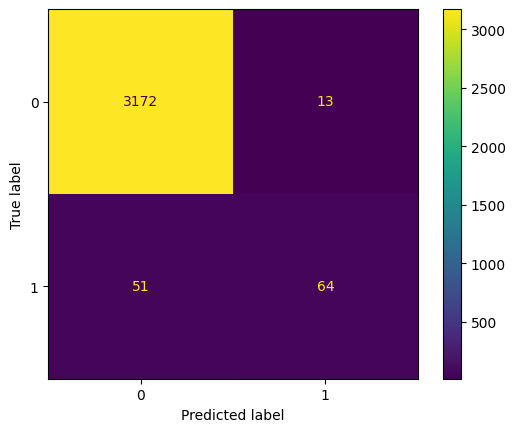

In [43]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

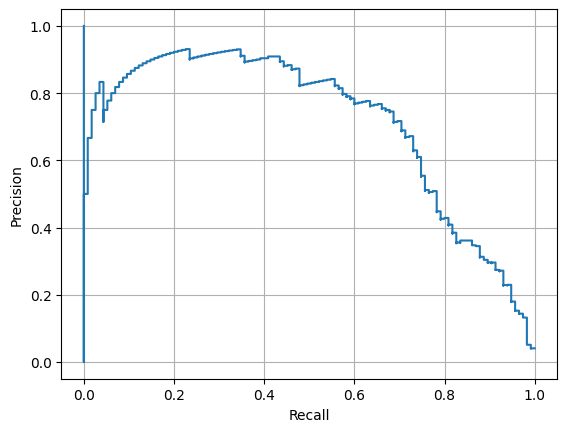

In [44]:
# precision recall curve
y_score = clf.decision_function(X_test)
prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
plt.grid()

# Explain Model Decisions
## Feature Importance - What are the Driving Factors for Machine Failure

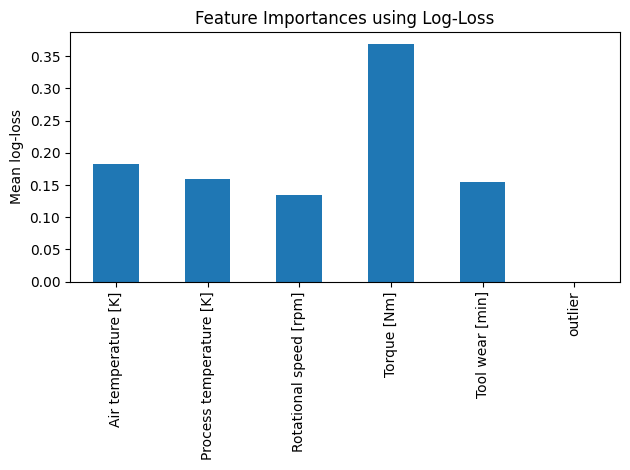

In [45]:
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using Log-Loss")
ax.set_ylabel("Mean log-loss")
fig.tight_layout()

## Explainable AI using Shapley Values

In [46]:
explainer = shap.TreeExplainer(
    model=clf,
    data = X_test, 
    feature_perturbation = "interventional",
    model_output='probability')

In [47]:
shap_values = explainer.shap_values(X_test, check_additivity=True)

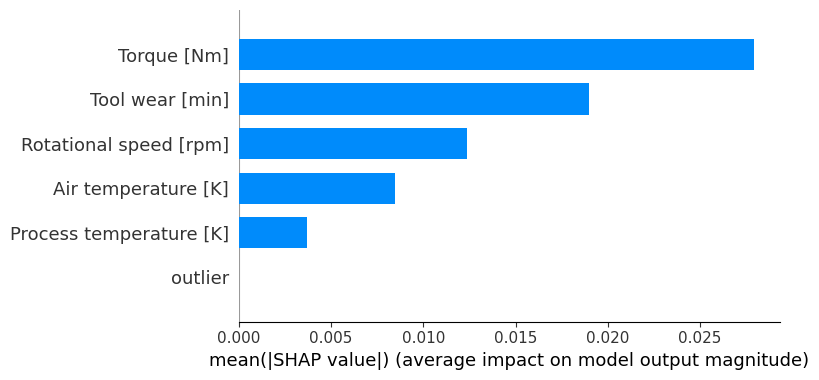

In [48]:
shap.summary_plot(
    shap_values=shap_values, 
    features=X_test, 
    plot_type='bar'
    )

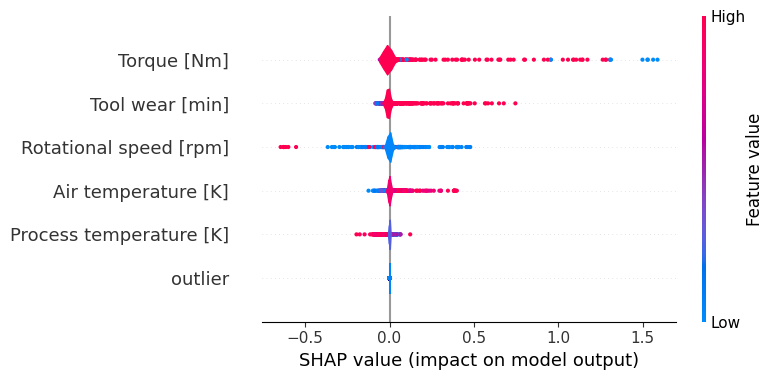

In [49]:
shap.summary_plot(
    shap_values=shap_values, 
    features=X_test, 
    plot_type='violin'
    )

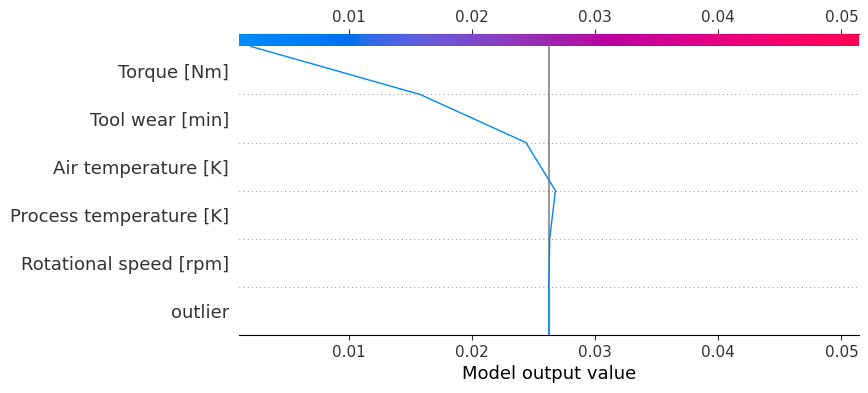

In [50]:
shap.decision_plot(
    base_value=explainer.expected_value,  
    shap_values=shap_values[1,:],
    feature_names=features)

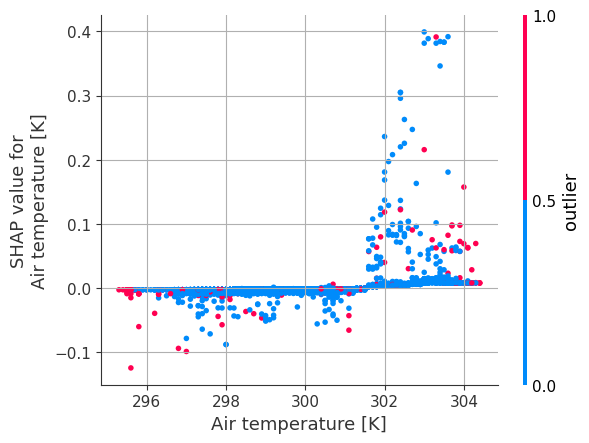

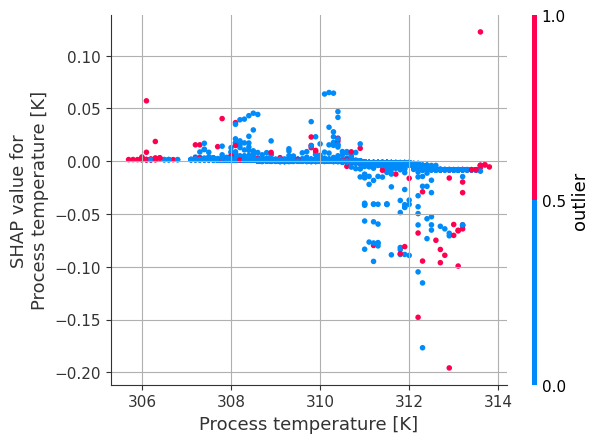

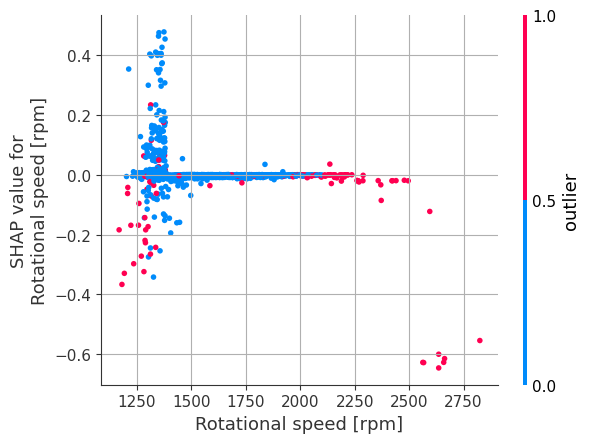

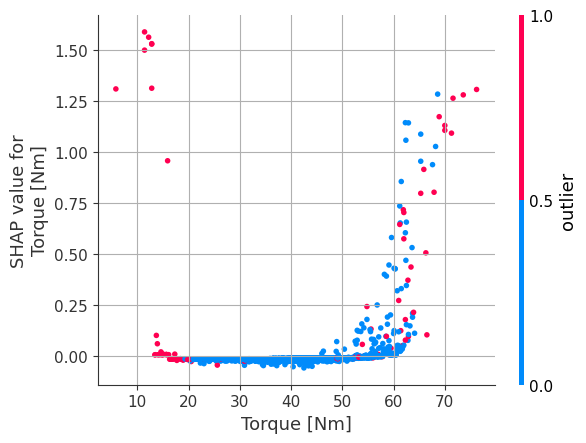

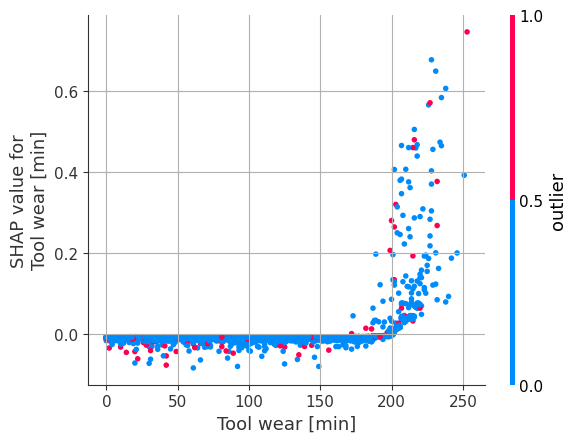

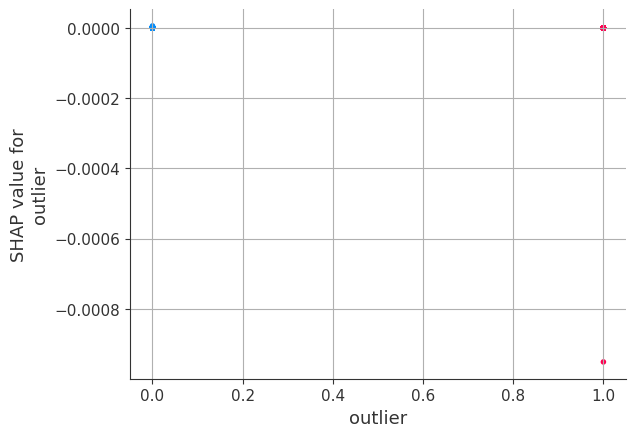

In [52]:

for f in features:
    fig, ax = plt.subplots(1,1)
    ax.grid()
    shap.dependence_plot(
        ind=f,
        shap_values=shap_values,
        features=X_test,
        interaction_index='outlier',
        ax=ax
    )
    
